In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import scipy
from scipy.signal import hilbert
from lagged_autocoherence import lagged_hilbert_autocoherence, generate_surrogate, filter_data, lagged_fourier_autocoherence
from utils import scale_noise
import colorednoise as cn

In [2]:
f=np.load('../output/sims/joint_amp_norm_factor/sim_results.npz')
lags=f['lags']
freqs=f['freqs']
lhc=f['lhc']
f_lhc_true=f['f_lhc_true']
f_lhc_false=f['f_lhc_false']
f_num_true=f['f_num_true']
f_num_false=f['f_num_false']
f_denom_true=f['f_denom_true']
f_denom_false=f['f_denom_false']
thresholds=f['thresholds']
f1=15

/tmp/ipykernel_21865/3218394878.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


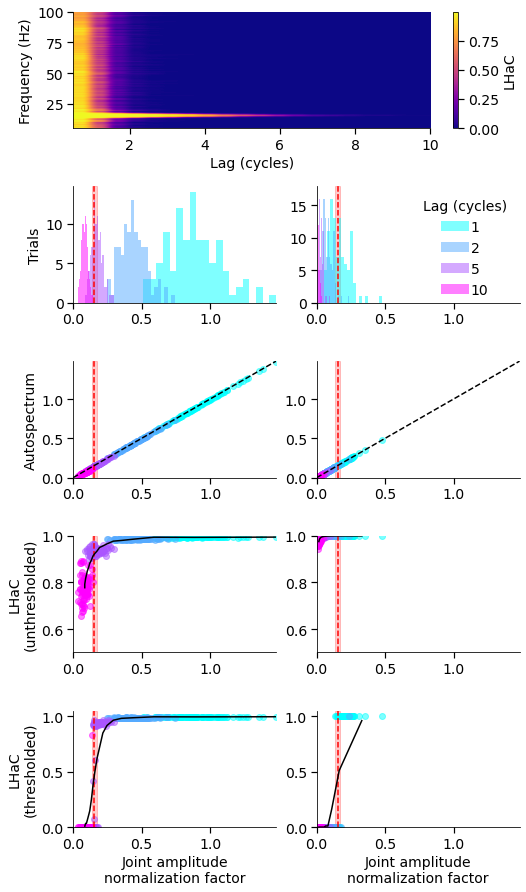

In [5]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

lags_to_plot = [1, 2, 5, 10]
lag_idx = np.array([np.argmin(np.abs(lags - lag)) for lag in lags_to_plot], dtype=int)
colors = cm.cool(np.linspace(0, 1, len(lags_to_plot)))
xlim = [0, np.max(np.hstack([f_denom_true[:, lag_idx].flatten(), f_denom_false[:, lag_idx].flatten()]))]

# Calculate threshold mean and std
threshold_mean = np.mean(thresholds)
threshold_std = np.std(thresholds)

def plot_threshold(ax):
    ax.axvline(threshold_mean, color='red', linestyle='--')
    ax.axvspan(threshold_mean - threshold_std, threshold_mean + threshold_std,
               color='red', alpha=0.2)
    
    
# Create figure with GridSpec
fig = plt.figure(figsize=(8, 15))
gs = GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1], hspace=0.5)

# Top row (spanning both columns) - empty
ax0 = fig.add_subplot(gs[0, :])
im=ax0.imshow(np.mean(lhc,axis=0),aspect='auto',origin='lower',cmap='plasma', extent=[lags[0], lags[-1], freqs[0], freqs[-1]])
ax0.set_xlabel('Lag (cycles)')
ax0.set_ylabel('Frequency (Hz)')
plt.colorbar(im,label='LHaC')

# Panels
axes = [fig.add_subplot(gs[i, j]) for i in range(1, 5) for j in range(2)]

# Panel 1: histogram for true
plot_threshold(axes[0])
for i, l_idx in enumerate(lag_idx):
    axes[0].hist(f_denom_true[:, l_idx], 20, density=False, alpha=.5, label=f'{lags_to_plot[i]}', color=colors[i])
axes[0].set_xlim(xlim)
axes[0].set_ylabel('Trials')

# Panel 2: histogram for false
plot_threshold(axes[1])
for i, l_idx in enumerate(lag_idx):
    axes[1].hist(f_denom_false[:, l_idx], 20, density=False, alpha=.5, label=f'{lags_to_plot[i]}', color=colors[i])
axes[1].set_xlim(xlim)
axes[1].legend(title='Lag (cycles)')

# Panel 3: num vs denom (true)
plot_threshold(axes[2])
for i, l_idx in enumerate(lag_idx):
    axes[2].scatter(f_denom_true[:, l_idx], np.abs(f_num_true)[:, l_idx], alpha=.5, color=colors[i])
max_val=np.max(f_denom_true[:,lag_idx])
axes[2].plot([0,max_val],[0,max_val],'k--')
axes[2].set_ylabel('Autospectrum')
axes[2].set_xlim(xlim)
axes[2].set_ylim(xlim)

# Panel 4: num vs denom (false)
plot_threshold(axes[3])
for i, l_idx in enumerate(lag_idx):
    axes[3].scatter(f_denom_false[:, l_idx], np.abs(f_num_false)[:, l_idx], alpha=.5, color=colors[i])
axes[3].plot([0,max_val],[0,max_val],'k--')
axes[3].set_xlim(xlim)
axes[3].set_ylim(xlim)

# Panel 5: unthresholded LHaC vs denom (true)
plot_threshold(axes[4])
for i, l_idx in enumerate(lag_idx):
    axes[4].scatter(f_denom_true[:, l_idx], f_lhc_true[:, l_idx], alpha=.5, color=colors[i])
axes[4].plot(np.mean(f_denom_true,axis=0), np.mean(f_lhc_true,axis=0),'k')
axes[4].set_ylabel('LHaC\n(unthresholded)')
axes[4].set_xlim(xlim)
axes[4].set_ylim([0.5, 1])

# Panel 6: unthresholded LHaC vs denom (false)
plot_threshold(axes[5])
for i, l_idx in enumerate(lag_idx):
    axes[5].scatter(f_denom_false[:, l_idx], f_lhc_false[:, l_idx], alpha=.5, color=colors[i])
axes[5].plot(np.mean(f_denom_false,axis=0), np.mean(f_lhc_false,axis=0),'k')
axes[5].set_xlim(xlim)
axes[5].set_ylim([0.5, 1])

# Panel 7: thresholded LHaC vs denom (true)
plot_threshold(axes[6])
f_idx=np.argmin(np.abs(freqs-f1))
for i, l_idx in enumerate(lag_idx):
    axes[6].scatter(f_denom_true[:, l_idx], lhc[:, f_idx, l_idx], alpha=.5, color=colors[i])
axes[6].plot(np.mean(f_denom_true,axis=0), np.mean(lhc[:, f_idx, :],axis=0),'k')
axes[6].set_xlabel('Joint amplitude\nnormalization factor')
axes[6].set_ylabel('LHaC\n(thresholded)')
axes[6].set_xlim(xlim)
axes[6].set_ylim([0.0, 1.05])

# Panel 8: thresholded LHaC vs denom (false)
plot_threshold(axes[7])
f_idx=np.argmin(np.abs(freqs-50))
for i, l_idx in enumerate(lag_idx):
    axes[7].scatter(f_denom_false[:, l_idx], lhc[:, f_idx, l_idx], alpha=.5, color=colors[i])
axes[7].plot(np.mean(f_denom_false,axis=0), np.mean(lhc[:, f_idx, :],axis=0),'k')
axes[7].set_xlabel('Joint amplitude\nnormalization factor')
axes[7].set_xlim(xlim)
axes[7].set_ylim([0.0, 1.05])


plt.tight_layout()

fig.savefig('../output/figures/figure_2.pdf')